# Setup Environment

This notebook works on building machine learning model, optimize training parameter to achieve best metric result by hyperparameter tuning, save model and then deploy model as an server endpoint. Web, applications or third-party service could use this enpdoint for infering data.

The inventory tracking system aims to automate and enhance inventory monitoring, recognizing and sorting tasks. Our output model aims to reduce manual labor, minimize errors, increase overall efficiency; and most important, simulate a full machine learning pipeline in a logistic data-processing job.

## 1. Preconfig

<h4>Installl modules</h4>

In [1]:
# Install packages for Debugging and Profiling on SageMaker
# 'smdebug' may have error with latest version, so we should use another version.
# Reference: https://pypi.org/project/smdebug/#history
!pip install -U torch torchvision
!pip install -U smdebug
!pip install -U seaborn plotly opencv-python shap imageio bokeh
!pip install -U sagemaker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 943.9 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 89.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 77.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 25.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 39.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 20.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 11.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 12.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━

<h4>Import modules</h4>

In [36]:
# Import any packages that you might need

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import boto3
import sagemaker
from sagemaker.predictor import Predictor
from sagemaker.pytorch import PyTorch
from sagemaker.pytorch import PyTorchModel
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.debugger import (
    Rule, ProfilerRule, rule_configs,
    DebuggerHookConfig, CollectionConfig,
    ProfilerConfig, FrameworkProfile, 
)

from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import random
import os
import requests
import json

from PIL import Image
from IPython.display import display

<h4>Configure environment</h4>

In [3]:
project_bucket = "capstone-project-00"
dataset_bucket = 'aft-vbi-pds'
role = "arn:aws:iam::008748484958:role/capstone-khangtictoc"
# Create channel for data input's location
train_loc = "s3://%s/dataset/bin-images/train" % project_bucket
validation_loc = "s3://%s/dataset/bin-images/valid" % project_bucket
test_loc = "s3://%s/dataset/bin-images/test" % project_bucket

channels = {
    "training": train_loc,
    "validation": validation_loc,
    "testing": test_loc
}

## 2. Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [ ]:

def download_and_arrange_data():
    with open('file_list.json', 'r') as f:
        d=json.load(f)
        # split data train =0.6, test=0.2, validation=0.2
        train = {}
        test = {}
        validation = {}
        for k, v in d.items():
            train[k], test[k] = train_test_split(d[k], test_size =0.4, random_state=0)
            test[k], validation[k] = train_test_split(test[k], test_size=0.5, random_state=0)
        download_images(train, 'train')
        download_images(test, 'test')
        download_images(validation, 'validation')

def download_images(files_list, data_path):
    s3_client = boto3.client('s3')
    data_path = os.path.join('dataset', 'bin-images', data_path)
    for k, v in files_list.items():
        print(f"Downloading Images with {k} objects to the path {data_path}")
        directory=os.path.join(data_path, k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_key_file = 'bin-images/' + file_name
            s3_client.download_file(dataset_bucket, s3_key_file,
                             os.path.join(directory, file_name))

download_and_arrange_data()

<h4>Upload data to S3</h4>

In [ ]:
!aws s3 sync ./dataset/ s3://{project_bucket}/dataset

## 3. Datas Visualization

*The Amazon Bin Image Dataset* contains over **500,000 images and metadata** from bins of a pod in an operating *Amazon Fulfillment Center*. The bin images in this dataset are captured as robot units carry pods as part of normal Amazon Fulfillment Center operations.

As for a large dataset, we plan to use only a subset of **10441** samples from the original dataset which is served as experiment tasks to examine the efficiency of the model. The subset only contains bin images that store the number of items between '1' and '5'. 

Let's examine dataset

<h4>Sample image</h4>

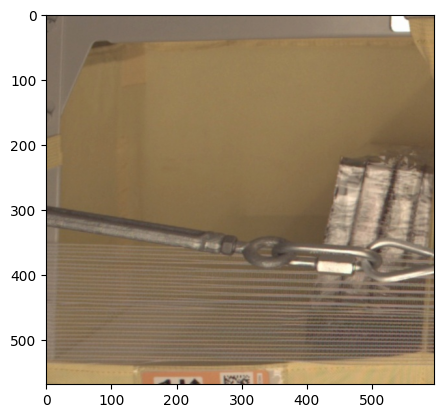

In [29]:
sample_path = "./dataset/bin-images/train/1/00009.jpg"
img = cv2.imread(sample_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

<h4>The number of images of each label</h4>

In [26]:
# Load the JSON data from the file
with open("file_list.json", "r") as file:
    data = json.load(file)

# Count the length of each list for each label
labels_length = {key: len(value) for key, value in data.items()}

In [27]:
labels_length

{'1': 1228, '2': 2299, '3': 2666, '4': 2373, '5': 1875}

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Total number of images:  10441
The average number of object for each bin:  3.131021932765061
------------------------------------------------------


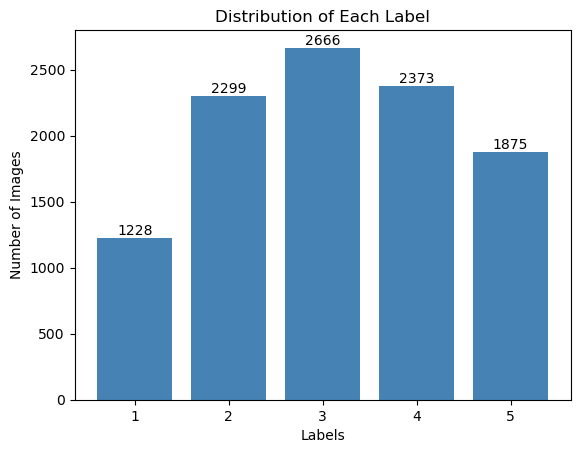

In [35]:
# Load the JSON data from the file
with open("file_list.json", "r") as file:
    data = json.load(file)

# Count the length of each list for each label
labels_length = {key: len(value) for key, value in data.items()}
# Count the average number of object for each bin 
avg_obj_each_bin = sum([int(key) * value for key, value in labels_length.items()])/sum(labels_length.values())

print("Total number of images: ", sum(labels_length.values()))
print("The average number of object for each bin: ", avg_obj_each_bin)
print("------------------------------------------------------")

# Drawing the chart
labels = list(labels_length.keys())
sizes = list(labels_length.values())

bars = plt.bar(labels, sizes, color='steelblue')
plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.title('Distribution of Each Label')

# Adding the text on top of the columns
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')

plt.show()

<h4>Distribution of all images'size (MB)</h4>

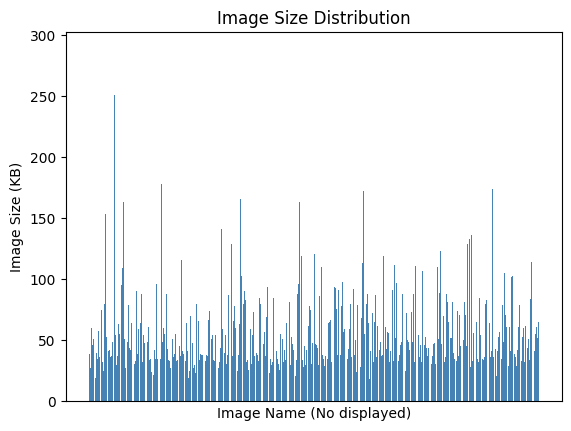

In [86]:
img_size_dict = {}
for dirpath, dirs, files in os.walk('./dataset/bin-images'):
    for file in files:
        image_path = os.path.join(dirpath, file)
        img_size = round(os.path.getsize(image_path) / 1024)
        img_size_dict[os.path.basename(image_path)] = img_size

# Plotting the image size distribution
labels = list(img_size_dict.keys())
sizes = list(img_size_dict.values())

plt.xlabel('Image Name (No displayed)')
plt.ylabel('Image Size (KB)')
plt.title('Image Size Distribution')
plt.bar(labels, sizes, color='steelblue')
plt.xticks([])

plt.show()

<h4> Image size in multiple range sizes </h4>

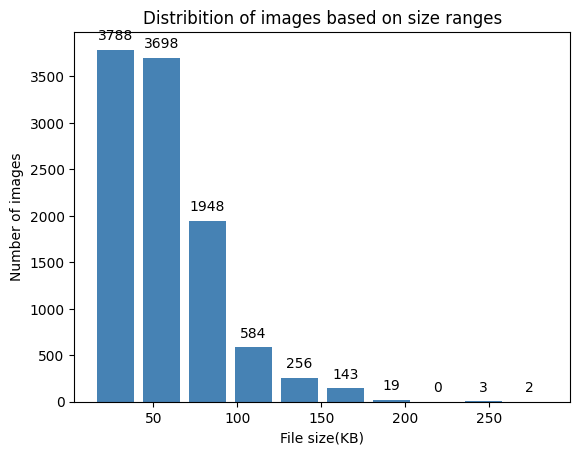

In [107]:
# Parameters
directory = './dataset'
min_size = min(img_size_dict.values())
max_size = max(img_size_dict.values())
step_size = 25

bin = (max_size - min_size) // step_size

# Collect image sizes
image_sizes_kb = []
for dirpath, dirs, files in os.walk(directory):
    for file in files:
        image_path = os.path.join(dirpath, file)
        image_size_kb = os.path.getsize(image_path) / 1024  # Convert bytes to KB
        image_sizes_kb.append(image_size_kb)

# Create histogram
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(image_sizes_kb, bins=bin, color='steelblue', rwidth=0.8)

# Annotate each bar with the count of items in the bin
for patch, count in zip(patches, counts):
    ax.annotate(str(int(count)), xy=(patch.get_x() + patch.get_width() / 2, patch.get_height()), 
                xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')

plt.xlabel('File size(KB)')
plt.ylabel('Number of images')
plt.title('Distribition of images based on size ranges')
plt.show()

<h4>Scatter Plot of Image Resolutions</h4>

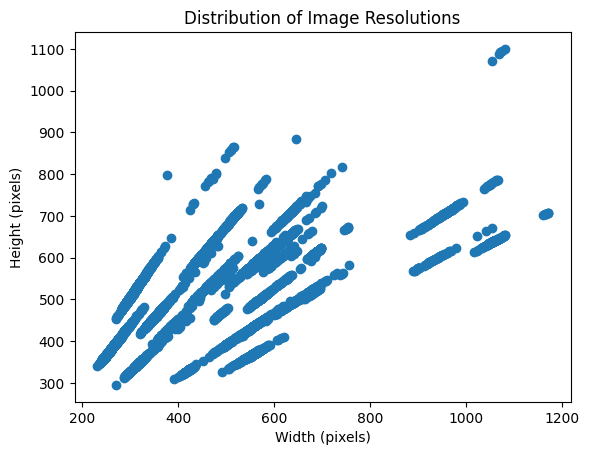

In [110]:
resolutions  = []
for dirpath, dirs, files in os.walk(directory):
    for file in files:
        image_path = os.path.join(dirpath, file)
        img = cv2.imread(image_path)
        resolution = img.shape[:2]
        resolutions.append(resolution)
resolutions = np.array(resolutions)
# Plot a scatter plot of the image resolutions
plt.scatter(resolutions[:, 0], resolutions[:, 1])
plt.title("Distribution of Image Resolutions")
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.show()

## 4. Hyperparameter Tuning

Hyperparameter optimization for achieving the most suitable set of params that fit the target metric


In [146]:
# Declare HP ranges, metrics etc.

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([16, 32, 64, 128, 256, 512]),
    "epochs": IntegerParameter(10, 20)
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [147]:
# Create estimators for HPs

estimator = PyTorch(
    role=role,
    instance_count=1,
    instance_type="ml.m5.4xlarge",
    source_dir="script",
    entry_point="hpo.py",
    framework_version="2.2",
    py_version="py310",
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=1,
    objective_type=objective_type,
)

In [148]:
# Fit HP Tuner
tuner.fit(inputs=channels, wait=True) # Include data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [149]:
# Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()


2024-07-08 20:52:56 Starting - Found matching resource for reuse
2024-07-08 20:52:56 Downloading - Downloading the training image
2024-07-08 20:52:56 Training - Training image download completed. Training in progress.
2024-07-08 20:52:56 Uploading - Uploading generated training model
2024-07-08 20:52:56 Completed - Resource released due to keep alive period expiry


In [150]:
# Create hyperparameter dict for the best model for later use
best_hyperparameters = {
    "lr": best_estimator.hyperparameters()['lr'],
    "batch-size": int(best_estimator.hyperparameters()['batch-size'].replace('"', '')),
    "epochs": int(best_estimator.hyperparameters()['epochs'])
}
best_hyperparameters

{'lr': '0.0011353714970396942', 'batch-size': 128, 'epochs': 19}

## 5. Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

In [4]:
collection_configs=[
    CollectionConfig(
        name="weights",
        parameters={
            "train.save_interval": "5",
            "eval.save_interval": "1"
        }
    ),
    CollectionConfig(
        name="gradients",
        parameters={
            "train.save_interval": "5",
            "eval.save_interval": "1"
        }
    ),
    CollectionConfig(
        name="biases",
        parameters={
            "train.save_interval": "5",
            "eval.save_interval": "1"
        }
    ),
    CollectionConfig(
        name="CrossEntopyLoss_output_0", 
        parameters={
            "include_regex": "CrossEntropyLoss_output_0",
            "train.save_interval": "1",
            "eval.save_interval": "1"
        }
    )
]

In [5]:
# Configure Debugger

debugger_hook_config = DebuggerHookConfig(
    #s3_output_path=debugger_s3_output,
    hook_parameters={
        "train.save_interval": "5",
        "eval.save_interval": "1"
    }
)

In [6]:
# Configure Profiler

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(num_steps=10),
    #s3_output_path=profiler_s3_output
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [7]:
# Set up the rules for debugging

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

In [13]:
estimator = PyTorch(
    source_dir="script",
    entry_point='train.py',
    
    base_job_name='inventory-monitoring-pytorch-image-classification',
    role=role,
    instance_count=1,
    instance_type='ml.c4.4xlarge',
    framework_version='1.4.0',
    py_version='py36',
    hyperparameters={'lr': '0.004909233792902113', 'batch-size': 256, 'epochs': '16'},
    
    rules=rules,
    debugger_hook_config=debugger_hook_config,
    profiler_config=profiler_config
)

estimator.fit({"training": "s3://{}/dataset/bin-images/".format(project_bucket)}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: inventory-monitoring-pytorch-image-clas-2024-07-24-04-51-43-882


2024-07-24 04:51:44 Starting - Starting the training job...
2024-07-24 04:52:09 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2024-07-24 04:52:35 Downloading - Downloading input data...
2024-07-24 04:53:09 Downloading - Downloading the training image......
2024-07-24 04:54:10 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-07-24 04:54:12,424 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-07-24 04:54:12,427 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2024-07-24 04:54:12,438 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-07-24

## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

## 6. Model Profiling and Debugging

### 6.1 Plot a debugging output.

In [14]:
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2024-07-24 07:52:42.489 default:132 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-008748484958/inventory-monitoring-pytorch-image-clas-2024-07-24-04-51-43-882/debug-output


In [15]:
print(trial.tensor_names())

[2024-07-24 07:52:44.683 default:132 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-07-24 07:52:45.704 default:132 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer1.2.relu_input_2', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.0.relu_input_2', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer2.1.relu_input_2', 'layer2.2.relu_input_0', 'layer2.2.relu_input_1', 'layer2.2.relu_input_2', 'layer2.3.relu_input_0', 'layer2.3.relu_input_1', 'layer2.3.relu_input_2', 'layer3.0.relu_input_0', 'layer3.0.relu_input_1', 'layer3.0.relu_input_2', 'layer3.1.relu_input_0', 'layer3.1.relu_input_1', 'layer3.1.rel

In [16]:
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.EVAL)))

1
1


In [17]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [18]:
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


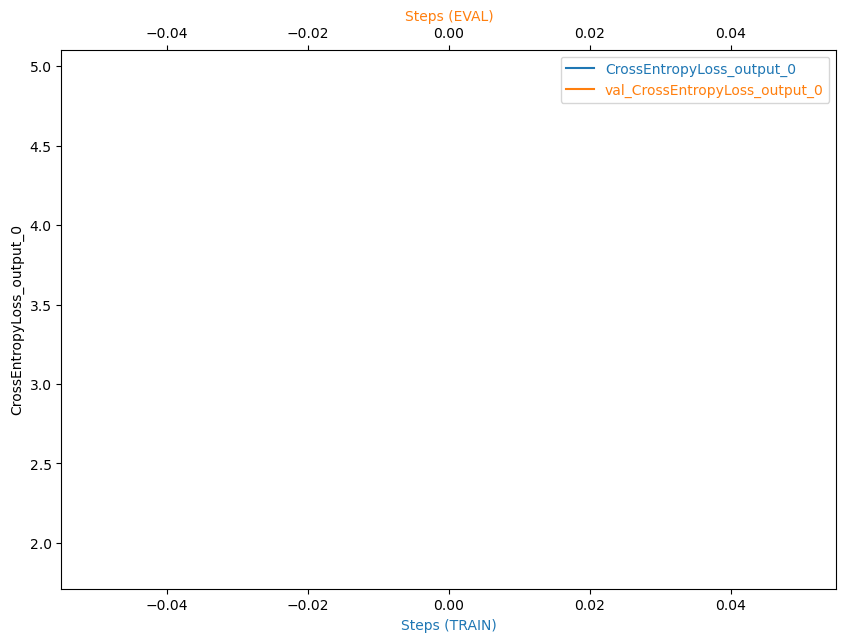

In [19]:
plot_tensor(trial, 'CrossEntropyLoss_output_0')

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

### 6.2 Display the profiler output

In [20]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print("Rule output S3 path: ", rule_output_path)
print("Save profile report to local ...")
!aws s3 cp {rule_output_path} ./ --recursive

Rule output S3 path:  s3://sagemaker-us-east-1-008748484958/inventory-monitoring-pytorch-image-clas-2024-07-24-04-51-43-882/rule-output
Save profile report to local ...
download: s3://sagemaker-us-east-1-008748484958/inventory-monitoring-pytorch-image-clas-2024-07-24-04-51-43-882/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-008748484958/inventory-monitoring-pytorch-image-clas-2024-07-24-04-51-43-882/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-008748484958/inventory-monitoring-pytorch-image-clas-2024-07-24-04-51-43-882/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-008748484958/inventory-monitoring-pytorch-image-c

In [21]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [22]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [ ]:
model_location = estimator.model_data
print(model_location)

## 7. Model Deploying and Querying

Locate where model are saved in S3. Make sure model are stored after training job is completed

In [23]:
model_location = estimator.model_data
print(model_location)

s3://sagemaker-us-east-1-008748484958/inventory-monitoring-pytorch-image-clas-2024-07-22-14-19-29-314/output/model.tar.gz


- Defined the predicting class: determine the serialize and deserialize method
- Create `inference.py` script to perform predicting for a incoming data request API. Reference: [https://course19.fast.ai/deployment_amzn_sagemaker.html](https://course19.fast.ai/deployment_amzn_sagemaker.html)

In [24]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [25]:
pytorch_model = PyTorchModel(
    source_dir="script",
    model_data=model_location, 
    role=role, 
    entry_point='inference.py',
    py_version='py3',
    framework_version='1.4',
    predictor_cls=ImagePredictor)

In [32]:
predictor = pytorch_model.deploy(
    initial_instance_count=1, 
    instance_type='ml.m5.large',
    endpoint_name="inventory-monitoring-endpoint-multi-instance"
)

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-008748484958/inventory-monitoring-pytorch-image-clas-2024-07-22-14-19-29-314/output/model.tar.gz), script artifact (script), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-008748484958/pytorch-inference-2024-07-22-17-25-18-982/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2024-07-22-17-36-48-028
INFO:sagemaker:Creating endpoint-config with name inventory-monitoring-endpoint-multi-instance
INFO:sagemaker:Creating endpoint with name inventory-monitoring-endpoint-multi-instance


------!

In [33]:
request_dict={ "url": "https://capstone-project-00.s3.amazonaws.com/predict_samples/00014.jpg" }
img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

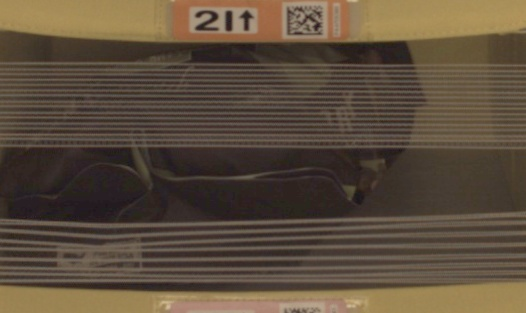

In [34]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [35]:
response = predictor.predict(img_bytes, initial_args = {"ContentType": "image/jpeg"})

View list of probabilities of each label

In [36]:
response

[[3.5001468658447266,
  4.805016040802002,
  4.875925064086914,
  4.884450912475586,
  3.5118863582611084,
  -6.081723213195801,
  -7.606815338134766,
  -6.340882778167725,
  -6.517319679260254,
  -7.2281951904296875,
  -5.18907356262207,
  -7.029324531555176,
  -7.002466678619385,
  -7.336719512939453,
  -7.652435779571533,
  -6.630293846130371,
  -6.965185642242432,
  -7.231863021850586,
  -6.4957427978515625,
  -7.438179969787598,
  -7.535483360290527,
  -6.218061447143555,
  -6.944362163543701,
  -6.690057754516602,
  -6.169773101806641,
  -7.164965629577637,
  -7.770097255706787,
  -7.545540809631348,
  -6.230835914611816,
  -4.182327747344971,
  -7.3100996017456055,
  -7.083276271820068,
  -6.636202335357666,
  -7.0727620124816895,
  -6.783613681793213,
  -7.697785377502441,
  -6.725381851196289,
  -6.63695764541626,
  -7.530029773712158,
  -6.382881164550781,
  -7.045375347137451,
  -7.088568687438965,
  -6.444756507873535,
  -6.791362762451172,
  -6.100887298583984,
  -6.812817

In [37]:
np.argmax(response, 1)

array([3])

In [38]:
# IMPORTANT) Shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: inventory-monitoring-endpoint-multi-instance
INFO:sagemaker:Deleting endpoint with name: inventory-monitoring-endpoint-multi-instance


### Cheaper Training and Cost Analysis
**TODO:** Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?

Apply spot instance to relatively reduce your cost

In [ ]:
estimator = PyTorch(
    source_dir="script",
    entry_point='train.py',

    use_spot_instances = True, 
    max_run=7200,
    max_wait=7200,
    
    base_job_name='inventory-monitoring-pytorch-image-classification',
    role=role,
    instance_count=1,
    instance_type='ml.c4.4xlarge',
    framework_version='1.4.0',
    py_version='py36',
    hyperparameters={'lr': '0.004909233792902113', 'batch-size': 256, 'epochs': '5'},
    
    rules=rules,
    debugger_hook_config=debugger_hook_config,
    profiler_config=profiler_config
)

estimator.fit({"training": "s3://{}/dataset/bin-images/".format(project_bucket)}, wait=True)

### Multi-Instance Training
Train your model on multiple instance

In [ ]:
estimator = PyTorch(
    source_dir="script",
    entry_point='train.py',
    
    base_job_name='inventory-monitoring-pytorch-image-classification',
    role=role,
    instance_count=3,
    instance_type='ml.c4.4xlarge',
    framework_version='1.4.0',
    py_version='py36',
    hyperparameters={'lr': '0.004909233792902113', 'batch-size': 256, 'epochs': '16'},
    
    rules=rules,
    debugger_hook_config=debugger_hook_config,
    profiler_config=profiler_config
)

estimator.fit({"training": "s3://{}/dataset/bin-images/".format(project_bucket)}, wait=True)